## Install libraries to the environment

In [7]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from faker import Faker
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight



# Generate synthetic data


In [8]:
from faker import Faker
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

# Inicialización de Faker para datos demográficos ficticios
fake = Faker()
data = []

# --- DATOS DE REFERENCIA PARA DISTRIBUCIONES ---
# TODO: NEED REAL RANGES DATA
dist_params = {
    'height': {'loc': 170, 'scale': 10, 'min': 150, 'max': 220}, # Altura (cm)
    'weight': {'loc': 75, 'scale': 20, 'min': 40, 'max': 200},  # Peso (kg)
    'ldl': {'loc': 120, 'scale': 40, 'min': 40, 'max': 300},     # LDL (mg/dL)
    'triglycerides': {'meanlog': np.log(150), 'sigma': 0.8, 'min': 30, 'max': 800}, # Triglicéridos (mg/dL) - Log-normal
    'glucose': {'loc': 90, 'scale': 20, 'min': 40, 'max': 400},   # Glucosa en ayunas (mg/dL)
    'hba1c': {'loc': 5.5, 'scale': 1.0, 'min': 4.0, 'max': 15.0},   # HbA1c (%)
    'systolic_bp': {'loc': 125, 'scale': 25, 'min': 60, 'max': 250}, # Presión Sistólica (mmHg)
    'diastolic_bp': {'loc': 80, 'scale': 15, 'min': 30, 'max': 150},# Presión Diastólica (mmHg)
    'creatinine_male': {'loc': 1.0, 'scale': 0.3, 'min': 0.3, 'max': 8.0}, # Creatinina (mg/dL) - Hombres
    'creatinine_female': {'loc': 0.8, 'scale': 0.25, 'min': 0.3, 'max': 8.0} # Creatinina (mg/dL) - Mujeres
}

# --- PARÁMETROS DE CORRELACIÓN ENTRE COMORBILIDADES ---
correlation_params = {
    'obesity_diabetes_prob_boost': 0.8,   # Aumento de prob de diabetes si obesidad
    'obesity_hypertension_prob_boost': 0.6, # Aumento de prob de hipertensión si obesidad
    'diabetes_hypertension_prob_boost': 0.5 # Aumento de prob de hipertensión si diabetes
}

num_samples = 10000 # Cantidad de pacientes ficticios a generar

for _ in range(num_samples):
    age = fake.random_int(min=18, max=65)
    height_params = dist_params['height']
    height = np.random.normal(loc=height_params['loc'], scale=height_params['scale'])
    height = max(height_params['min'], min(height_params['max'], round(height)))

    weight_params = dist_params['weight']
    weight = np.random.normal(loc=weight_params['loc'], scale=weight_params['scale'])
    weight = max(weight_params['min'], min(weight_params['max'], round(weight)))

    bmi = weight / (height/100)**2

    ldl_params = dist_params['ldl']
    ldl = np.random.normal(loc=ldl_params['loc'], scale=ldl_params['scale'])
    ldl = max(ldl_params['min'], min(ldl_params['max'], round(ldl)))

    triglycerides_params = dist_params['triglycerides']
    triglycerides = np.random.lognormal(mean=triglycerides_params['meanlog'], sigma=triglycerides_params['sigma'])
    triglycerides = max(triglycerides_params['min'], min(triglycerides_params['max'], round(triglycerides)))

    glucose_params = dist_params['glucose']
    glucose = np.random.normal(loc=glucose_params['loc'], scale=glucose_params['scale'])
    glucose = max(glucose_params['min'], min(glucose_params['max'], round(glucose)))

    hba1c_params = dist_params['hba1c']
    hba1c = np.random.normal(loc=hba1c_params['loc'], scale=hba1c_params['scale'])
    hba1c = max(hba1c_params['min'], min(hba1c_params['max'], round(hba1c, 1)))

    genetic_condition = np.random.binomial(1, 0.1)

    systolic_bp_params = dist_params['systolic_bp']
    systolic_bp = np.random.normal(loc=systolic_bp_params['loc'], scale=systolic_bp_params['scale'])
    systolic_bp = max(systolic_bp_params['min'], min(systolic_bp_params['max'], round(systolic_bp)))

    diastolic_bp_params = dist_params['diastolic_bp']
    diastolic_bp = np.random.normal(loc=diastolic_bp_params['loc'], scale=diastolic_bp_params['scale'])
    diastolic_bp = max(diastolic_bp_params['min'], min(diastolic_bp_params['max'], round(diastolic_bp)))

    genero_num = fake.random_int(0, 1) # 0: femenino, 1: masculino
    genero = "masculino" if genero_num == 1 else "femenino"

    creatinine_params = dist_params['creatinine_male'] if genero_num == 1 else dist_params['creatinine_female']
    creatinine = np.random.normal(loc=creatinine_params['loc'], scale=creatinine_params['scale'])
    creatinine = max(creatinine_params['min'], min(creatinine_params['max'], round(creatinine, 1)))

    creatinine_alto_umbral = 1.3 if genero_num == 1 else 1.2
    creatinine_medio_umbral = 1.2 if genero_num == 1 else 1.1
    creatinine_bajo_umbral = 1.0 if genero_num == 1 else 0.9


    # --- CÁLCULO DE PROBABILIDADES DE COMORBILIDADES CON CORRELACIONES Y DISTRIBUCIONES PRECISAS ---

    obesity_probability = 0

    if bmi > 40:
        obesity_probability += 0.9
    elif bmi > 35:
        obesity_probability += 0.7
    elif bmi > 30:
        obesity_probability += 0.5
    elif bmi > 25:
        obesity_probability += 0.2

    if ldl > 160:
        obesity_probability += 0.2
    elif ldl > 130:
        obesity_probability += 0.1

    if triglycerides > 300:
        obesity_probability += 0.2
    elif triglycerides > 200:
        obesity_probability += 0.1

    if genetic_condition == 1:
        obesity_probability += 0.3

    obesity_probability = min(obesity_probability, 1)
    obesity_random_factor = np.random.rand()
    obesity = 1 if obesity_probability > 0.4 + obesity_random_factor * 0.4 else 0


    diabetes_probability = 0
    diabetes = 0

    if obesity == 1: # Correlación obesidad-diabetes
        diabetes_probability += correlation_params['obesity_diabetes_prob_boost']

    if hba1c >= 6.5 or glucose > 126:
        diabetes = 1
    else:
        if glucose > 200:
            diabetes_probability += 0.6
        elif glucose > 150:
            diabetes_probability += 0.4
        elif glucose > 110:
            diabetes_probability += 0.15

        if hba1c > 6.0 and hba1c < 6.5:
            diabetes_probability += 0.4
        elif hba1c > 5.7 and hba1c <= 6.0:
            diabetes_probability += 0.2

        if genetic_condition == 1:
            diabetes_probability += 0.2

        diabetes_probability = min(diabetes_probability, 1)
        diabetes_random_factor = np.random.rand()
        diabetes = 1 if diabetes_probability > 0.3 + diabetes_random_factor * 0.45 else 0


    hypertension_probability = 0

    if obesity == 1: # Correlación obesidad-hipertensión
        hypertension_probability += correlation_params['obesity_hypertension_prob_boost']
    if diabetes == 1: # Correlación diabetes-hipertensión
        hypertension_probability += correlation_params['diabetes_hypertension_prob_boost']


    if age < 60:
        if systolic_bp > 180 or diastolic_bp > 110:
            hypertension_probability += 0.9
        elif systolic_bp > 160 or diastolic_bp > 100:
            hypertension_probability += 0.8
        elif systolic_bp > 140:
            hypertension_probability += 0.7
        elif systolic_bp > 130 or diastolic_bp > 80:
            hypertension_probability += 0.5
        elif systolic_bp > 120:
            hypertension_probability += 0.2
    else:
        if systolic_bp > 180 or diastolic_bp > 110:
            hypertension_probability += 0.9
        elif systolic_bp > 160 or diastolic_bp > 100:
            hypertension_probability += 0.8
        elif systolic_bp > 150:
            hypertension_probability += 0.7
        elif systolic_bp > 140 or diastolic_bp > 90:
            hypertension_probability += 0.5
        elif systolic_bp > 130:
            hypertension_probability += 0.2


    if creatinine > creatinine_alto_umbral:
        hypertension_probability += 0.7
    elif creatinine > creatinine_medio_umbral:
        hypertension_probability += 0.4
    elif creatinine > creatinine_bajo_umbral:
        hypertension_probability += 0.2

    if diastolic_bp > 110:
        hypertension_probability += 0.6
    elif diastolic_bp > 100:
        hypertension_probability += 0.5
    elif diastolic_bp > 90:
        hypertension_probability += 0.4
    elif diastolic_bp > 80:
        hypertension_probability += 0.2

    if age > 70:
        hypertension_probability += 0.5
    elif age > 60:
        hypertension_probability += 0.3
    elif age > 50:
        hypertension_probability += 0.1

    if ldl > 190:
        hypertension_probability += 0.2
    elif ldl > 160:
        hypertension_probability += 0.1

    if genetic_condition == 1:
        hypertension_probability += 0.2

    hypertension_probability = min(hypertension_probability, 1)
    hypertension_random_factor = np.random.rand()
    hipertension = 1 if hypertension_probability > 0.4 + hypertension_random_factor * 0.45 else 0


    data.append({
        'edad' : age,
        'altura' : height,
        'peso' : weight,
        'imc' : bmi,
        'ldl' : ldl,
        'trigliceridos' : triglycerides,
        'glucosa_ayunas' : glucose,
        'hba1c' : hba1c,
        'condicion_genetica' : genetic_condition,
        'genero': genero_num,
        'obesidad' : obesity,
        'diabetes' : diabetes,
        'presion_arterial_sistolica': systolic_bp,
        'presion_arterial_diastolica': diastolic_bp,
        'creatinina': creatinine,
        'hipertension': hipertension
    })

df = pd.DataFrame(data)

# --- INGENIERÍA DE CARACTERÍSTICAS: INTERACCIONES ---
df['imc_edad_interaccion'] = df['imc'] * df['edad']
df['ratio_presion_arterial'] = df['presion_arterial_sistolica'] / (df['presion_arterial_diastolica'] + 1e-6)
df['glucosa_hba1c_interaccion'] = df['glucosa_ayunas'] * df['hba1c']

# --- INGENIERÍA DE CARACTERÍSTICAS: CATEGORIZACIÓN DE VARIABLES CONTINUAS ---
bins_edad = [18, 30, 40, 50, 65]
labels_edad = ['18-29', '30-39', '40-49', '50+']
df['edad_categoria'] = pd.cut(df['edad'], bins=bins_edad, labels=labels_edad, right=False)
df = pd.get_dummies(df, columns=['edad_categoria'], prefix='edad_cat', drop_first=False)

bins_imc = [0, 25, 30, 35, 40, 100]
labels_imc = ['normal', 'sobrepeso', 'obesidad_g1', 'obesidad_g2', 'obesidad_g3']
df['imc_categoria'] = pd.cut(df['imc'], bins=bins_imc, labels=labels_imc, right=False)
df = pd.get_dummies(df, columns=['imc_categoria'], prefix='imc_cat', drop_first=True)

# Model training

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

# Suponiendo que 'df' ya está cargado y contiene tus datos

# --- DEFINICIÓN DE FEATURES Y LABELS PARA MODELOS ACTUALIZADOS ---
# DICCIONARIOS DE MAPEO INVERTIDOS:  NOMBRE CORTO (Clave) -> NOMBRE DESCRIPTIVO (Valor)
feature_name_mapping_obesity = {
    'imc_cat_sobrepeso': 'IMC Categoría: Sobrepeso',
    'imc_cat_obesidad_g1': 'IMC Categoría: Obesidad Grado 1',
    'imc_cat_obesidad_g2': 'IMC Categoría: Obesidad Grado 2',
    'imc_cat_obesidad_g3': 'IMC Categoría: Obesidad Grado 3',
    'ldl': 'Colesterol LDL (mg/dL)',
    'trigliceridos': 'Triglicéridos (mg/dL)',
    'condicion_genetica': 'Condición Genética (Sí/No)',
    'genero': 'Género (Masculino=1, Femenino=0)',
    'imc_edad_interaccion': 'Interacción IMC * Edad'
}

feature_name_mapping_diabetes = {
    'glucosa_ayunas': 'Glucosa en Ayunas (mg/dL)',
    'hba1c': 'HbA1c (%)',
    'condicion_genetica': 'Condición Genética (Sí/No)',
    'genero': 'Género (Masculino=1, Femenino=0)',
    'glucosa_hba1c_interaccion': 'Interacción Glucosa * HbA1c',
    'imc_cat_sobrepeso': 'IMC Categoría: Sobrepeso',
    'imc_cat_obesidad_g1': 'IMC Categoría: Obesidad Grado 1',
    'imc_cat_obesidad_g2': 'IMC Categoría: Obesidad Grado 2',
    'imc_cat_obesidad_g3': 'IMC Categoría: Obesidad Grado 3',
    'edad_cat_18-29': 'Edad Categoría: 18-29 años',
    'edad_cat_30-39': 'Edad Categoría: 30-39 años',
    'edad_cat_40-49': 'Edad Categoría: 40-49 años',
    'edad_cat_50+': 'Edad Categoría: 50+ años'
}

feature_name_mapping_hipertension = {
    'presion_arterial_sistolica': 'Presión Arterial Sistólica (mmHg)',
    'presion_arterial_diastolica': 'Presión Arterial Diastólica (mmHg)',
    'creatinina': 'Creatinina (mg/dL)',
    'condicion_genetica': 'Condición Genética (Sí/No)',
    'genero': 'Género (Masculino=1, Femenino=0)',
    'edad_cat_50+': 'Edad Categoría: 50+ años',
    'imc_cat_sobrepeso': 'IMC Categoría: Sobrepeso',
    'imc_cat_obesidad_g1': 'IMC Categoría: Obesidad Grado 1',
    'imc_cat_obesidad_g2': 'IMC Categoría: Obesidad Grado 2',
    'imc_cat_obesidad_g3': 'IMC Categoría: Obesidad Grado 3',
    'ratio_presion_arterial': 'Ratio Presión Sistólica / Diastólica',
    'imc_edad_interaccion': 'Interacción IMC * Edad'
}

features_obesity = [ # LISTA CON NOMBRES CORTOS (REALES) PARA OBESIDAD
    'imc_cat_sobrepeso',
    'imc_cat_obesidad_g1',
    'imc_cat_obesidad_g2',
    'imc_cat_obesidad_g3',
    'ldl',
    'trigliceridos',
    'condicion_genetica',
    'genero',
    'imc_edad_interaccion'
]

features_diabetes = [ # LISTA CON NOMBRES CORTOS (REALES) PARA DIABETES
    'glucosa_ayunas',
    'hba1c',
    'condicion_genetica',
    'genero',
    'glucosa_hba1c_interaccion',
    'imc_cat_sobrepeso',
    'imc_cat_obesidad_g1',
    'imc_cat_obesidad_g2',
    'imc_cat_obesidad_g3',
    'edad_cat_18-29',
    'edad_cat_30-39',
    'edad_cat_40-49',
    'edad_cat_50+'
]

features_hipertension = [ # LISTA CON NOMBRES CORTOS (REALES) PARA HIPERTENSIÓN
    'presion_arterial_sistolica',
    'presion_arterial_diastolica',
    'creatinina',
    'condicion_genetica',
    'genero',
    'edad_cat_50+',
    'imc_cat_sobrepeso',
    'imc_cat_obesidad_g1',
    'imc_cat_obesidad_g2',
    'imc_cat_obesidad_g3',
    'ratio_presion_arterial',
    'imc_edad_interaccion'
]

labels_obesity = df['obesidad']
labels_diabetes = df['diabetes']
labels_hipertension = df['hipertension']


# --- DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA ---
X_train_obesity, X_test_obesity, y_train_obesity, y_test_obesity = train_test_split(
    df[features_obesity], labels_obesity, test_size=0.2, random_state=42, stratify=df['obesidad']
)
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
    df[features_diabetes], labels_diabetes, test_size=0.2, random_state=42, stratify=df['diabetes']
)
X_train_hipertension, X_test_hipertension, y_train_hipertension, y_test_hipertension = train_test_split(
    df[features_hipertension], labels_hipertension, test_size=0.2, random_state=42, stratify=df['hipertension']
)

# --- CALCULAR PESOS DE CLASE PARA MANEJAR DESBALANCE (SIN CAMBIOS) ---
class_weight_dict_obesity = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_obesity), y=y_train_obesity)))
class_weight_dict_diabetes = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_diabetes), y=y_train_diabetes)))
class_weight_dict_hipertension = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_hipertension), y=y_train_hipertension)))

# --- ESCALADO DE CARACTERÍSTICAS (Adaptado para usar solo características numéricas) ---
numeric_features_obesity = ['ldl', 'trigliceridos', 'genero', 'imc_edad_interaccion']
numeric_features_diabetes = ['glucosa_ayunas', 'hba1c', 'genero', 'glucosa_hba1c_interaccion']
numeric_features_hipertension = ['presion_arterial_sistolica', 'presion_arterial_diastolica', 'creatinina', 'genero', 'ratio_presion_arterial', 'imc_edad_interaccion']

scaler_obesity = StandardScaler()
scaler_obesity.fit(X_train_obesity[numeric_features_obesity])
X_train_obesity_scaled = X_train_obesity.copy()
X_test_obesity_scaled = X_test_obesity.copy()
X_train_obesity_scaled[numeric_features_obesity] = scaler_obesity.transform(X_train_obesity[numeric_features_obesity])
X_test_obesity_scaled[numeric_features_obesity] = scaler_obesity.transform(X_test_obesity[numeric_features_obesity])

scaler_diabetes = StandardScaler()
scaler_diabetes.fit(X_train_diabetes[numeric_features_diabetes])
X_train_diabetes_scaled = X_train_diabetes.copy()
X_test_diabetes_scaled = X_test_diabetes.copy()
X_train_diabetes_scaled[numeric_features_diabetes] = scaler_diabetes.transform(X_train_diabetes[numeric_features_diabetes])
X_test_diabetes_scaled[numeric_features_diabetes] = scaler_diabetes.transform(X_test_diabetes[numeric_features_diabetes])

scaler_hipertension = StandardScaler()
scaler_hipertension.fit(X_train_hipertension[numeric_features_hipertension])
X_train_hipertension_scaled = X_train_hipertension.copy()
X_test_hipertension_scaled = X_test_hipertension.copy()
X_train_hipertension_scaled[numeric_features_hipertension] = scaler_hipertension.transform(X_train_hipertension[numeric_features_hipertension])
X_test_hipertension_scaled[numeric_features_hipertension] = scaler_hipertension.transform(X_test_hipertension[numeric_features_hipertension])


# --- ENTRENAMIENTO DE MODELOS CON GRIDSEARCH Y CROSS-VALIDATION ---
param_grid_obesity = { # Param grid simplificado para obesidad (PRUEBA)
    'n_estimators': [100, 200, 300], # Reducido para probar más rápido
    'max_depth': [5, 10, 15],      # Reducido para probar más rápido
    'min_samples_split': [2, 5, 10], # Reducido para probar más rápido
    'min_samples_leaf': [1, 2, 4],  # Reducido para probar más rápido
    'class_weight': ['balanced'] #  Probamos solo 'balanced' para obesity (SIMPLIFICADO para DEBUG)
}


param_grid_diabetes = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', class_weight_dict_diabetes] # Incluye 'balanced' y el diccionario calculado
}

param_grid_hipertension = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', class_weight_dict_hipertension] # Incluye 'balanced' y el diccionario calculado
}


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reducido n_splits para probar más rápido

# --- GRIDSEARCH PARA MODELO DE OBESIDAD ---
grid_search_obesity = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_obesity, # Usamos param_grid_obesity SIMPLIFICADO para DEBUG
    cv=cv,
    scoring='accuracy', # Puedes cambiar a 'f1' u otra métrica
    n_jobs=-1 # Usa todos los cores disponibles (ajusta si es necesario)
)
grid_search_obesity.fit(X_train_obesity_scaled, y_train_obesity)
best_obesity_model = grid_search_obesity.best_estimator_
print("Mejores parámetros GridSearchCV para modelo de obesidad:", grid_search_obesity.best_params_)

# --- GRIDSEARCH PARA MODELO DE DIABETES ---
grid_search_diabetes = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_diabetes, # Usamos param_grid_diabetes original
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_diabetes.fit(X_train_diabetes_scaled, y_train_diabetes)
best_diabetes_model = grid_search_diabetes.best_estimator_
print("Mejores parámetros GridSearchCV para modelo de diabetes:", grid_search_diabetes.best_params_)

# --- GRIDSEARCH PARA MODELO DE HIPERTENSIÓN ---
grid_search_hipertension = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_hipertension, # Usamos param_grid_hipertension original
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_hipertension.fit(X_train_hipertension_scaled, y_train_hipertension)
best_hipertension_model = grid_search_hipertension.best_estimator_
print("Mejores parámetros GridSearchCV para modelo de hipertensión:", grid_search_hipertension.best_params_)


print("\nModelos entrenados con éxito con GridSearchCV y Cross-Validation.")
print("Modelos entrenados con éxito.")

Mejores parámetros GridSearchCV para modelo de obesidad: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mejores parámetros GridSearchCV para modelo de diabetes: {'class_weight': {0: np.float64(0.8748906386701663), 1: np.float64(1.1668611435239207)}, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mejores parámetros GridSearchCV para modelo de hipertensión: {'class_weight': {0: np.float64(2.2346368715083798), 1: np.float64(0.644122383252818)}, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

Modelos entrenados con éxito con GridSearchCV y Cross-Validation.
Modelos entrenados con éxito.


# Model evaluation

In [10]:
# --- Función para Categorizar Riesgo ---
def risk_categority(prob, medium_low_umbral=0.5, medium_high_umbral=0.8):
    """
    Categoriza la probabilidad en riesgo bajo, medio o alto.
    """
    if prob < medium_low_umbral:
        return "Bajo"
    elif prob < medium_high_umbral:
        return "Medio"
    else:
        return "Alto"

print("\n--- EVALUACIÓN DEL MODELO DE OBESIDAD (MEJOR MODELO DE GRIDSEARCH) ---")
y_pred_obesity_binary = best_obesity_model.predict(X_test_obesity_scaled)
y_pred_prob_obesity = best_obesity_model.predict_proba(X_test_obesity_scaled)[:, 1]
y_pred_obesity_categoria = [risk_categority(prob) for prob in y_pred_prob_obesity]
accuracy_obesity = accuracy_score(y_test_obesity, y_pred_obesity_binary)
print(f'Precisión del modelo de obesidad (GridSearchCV): {accuracy_obesity:.2f}')
print(classification_report(y_test_obesity, y_pred_obesity_binary))

print("\n--- EVALUACIÓN DEL MODELO DE DIABETES (MEJOR MODELO DE GRIDSEARCH) ---")
y_pred_diabetes_binary = best_diabetes_model.predict(X_test_diabetes_scaled)
y_pred_prob_diabetes = best_diabetes_model.predict_proba(X_test_diabetes_scaled)[:, 1]
y_pred_diabetes_categoria = [risk_categority(prob) for prob in y_pred_prob_diabetes]
accuracy_diabetes = accuracy_score(y_test_diabetes, y_pred_diabetes_binary)
print(f'Precisión del modelo de diabetes (GridSearchCV): {accuracy_diabetes:.2f}')
print(classification_report(y_test_diabetes, y_pred_diabetes_binary))

print("\n--- EVALUACIÓN DEL MODELO DE HIPERTENSIÓN (MEJOR MODELO DE GRIDSEARCH) ---")
y_pred_hipertension_binary = best_hipertension_model.predict(X_test_hipertension_scaled)
y_pred_prob_hipertension = best_hipertension_model.predict_proba(X_test_hipertension_scaled)[:, 1]
y_pred_hipertension_categoria = [risk_categority(prob) for prob in y_pred_prob_hipertension]
accuracy_hipertension = accuracy_score(y_test_hipertension, y_pred_hipertension_binary)
print(f'Precisión del modelo de hipertensión (GridSearchCV): {accuracy_hipertension:.2f}')
print(classification_report(y_test_hipertension, y_pred_hipertension_binary))


--- EVALUACIÓN DEL MODELO DE OBESIDAD (MEJOR MODELO DE GRIDSEARCH) ---
Precisión del modelo de obesidad (GridSearchCV): 0.92
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1500
           1       0.82      0.88      0.85       500

    accuracy                           0.92      2000
   macro avg       0.89      0.91      0.90      2000
weighted avg       0.92      0.92      0.92      2000


--- EVALUACIÓN DEL MODELO DE DIABETES (MEJOR MODELO DE GRIDSEARCH) ---
Precisión del modelo de diabetes (GridSearchCV): 0.91
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1143
           1       0.86      0.93      0.89       857

    accuracy                           0.91      2000
   macro avg       0.90      0.91      0.90      2000
weighted avg       0.91      0.91      0.91      2000


--- EVALUACIÓN DEL MODELO DE HIPERTENSIÓN (MEJOR MODELO DE GRIDSEARCH) ---
Precisión del mode

# Export model in pkl and scaler 

In [13]:
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

with open(os.path.join(MODEL_DIR, "scaler_obesity.pkl"), "wb") as file:
    pickle.dump(scaler_obesity, file)
with open(os.path.join(MODEL_DIR, "obesity_model.pkl"), "wb") as file:
    pickle.dump(best_obesity_model, file)

with open(os.path.join(MODEL_DIR, "scaler_diabetes.pkl"), "wb") as file:
    pickle.dump(scaler_diabetes, file)
with open(os.path.join(MODEL_DIR, "diabetes_model.pkl"), "wb") as file:
    pickle.dump(best_diabetes_model, file)

with open(os.path.join(MODEL_DIR, "scaler_hipertension.pkl"), "wb") as file:
    pickle.dump(scaler_hipertension, file)
with open(os.path.join(MODEL_DIR, "hipertension_model.pkl"), "wb") as file:
    pickle.dump(best_hipertension_model, file)

print(f"Modelos y scalers guardados en el directorio '{MODEL_DIR}'")

Modelos y scalers guardados en el directorio '../models'


# Graphics about the training

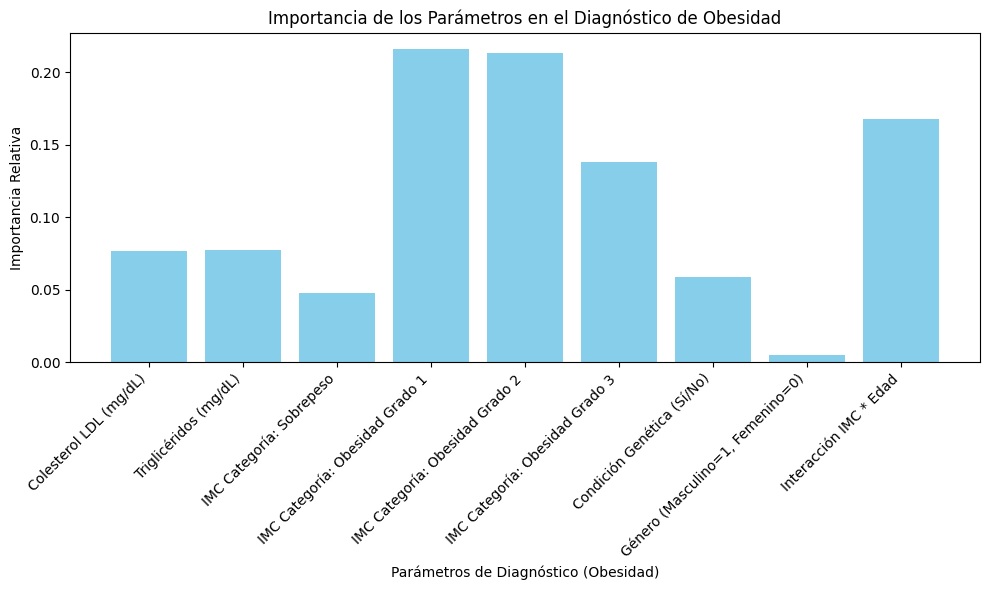

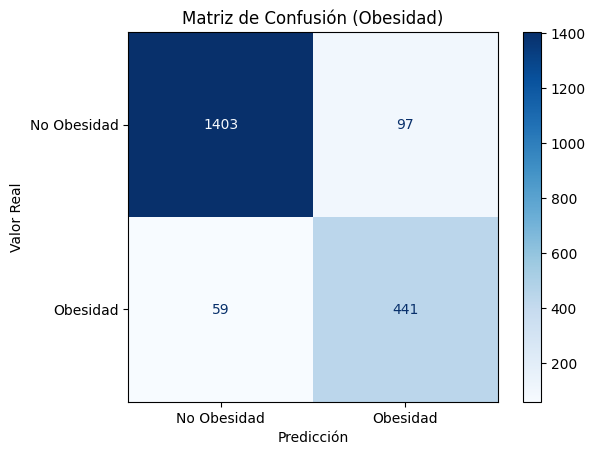

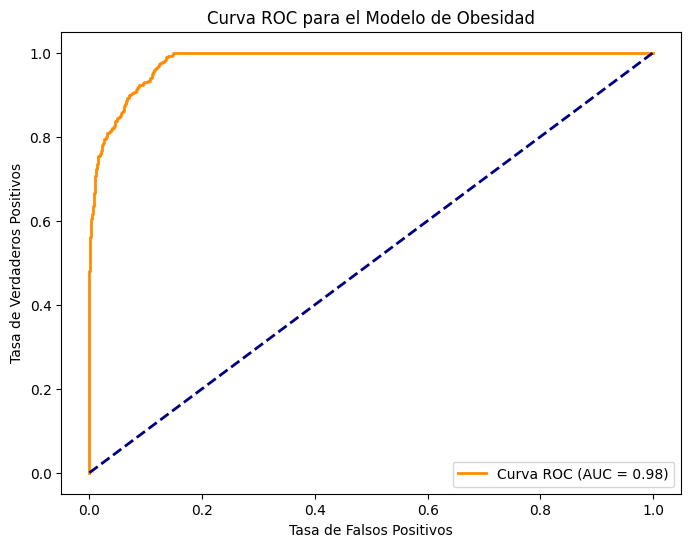

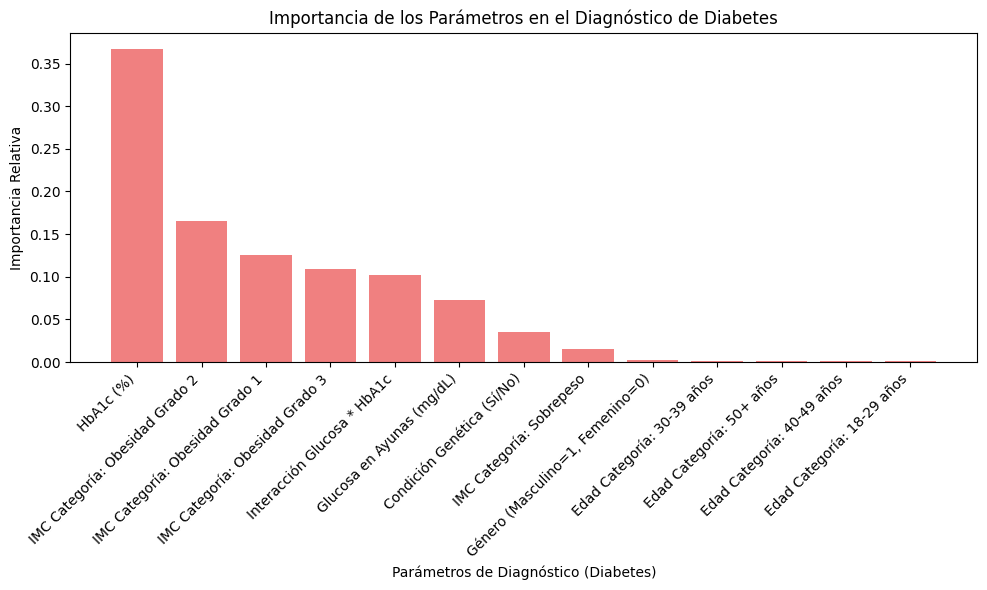

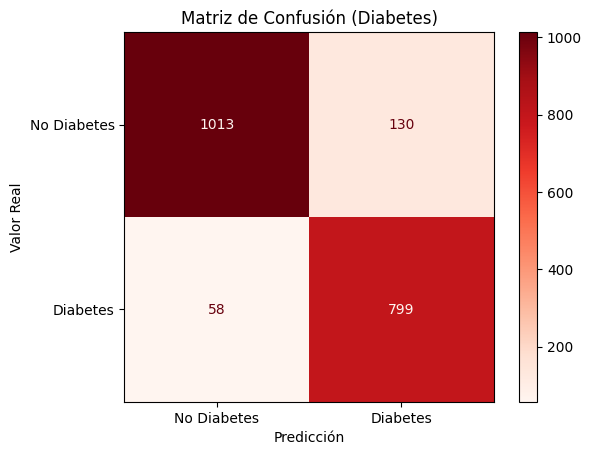

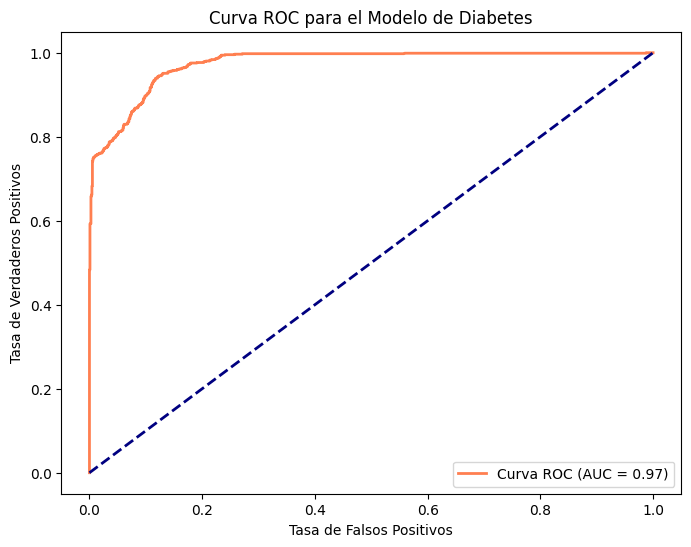

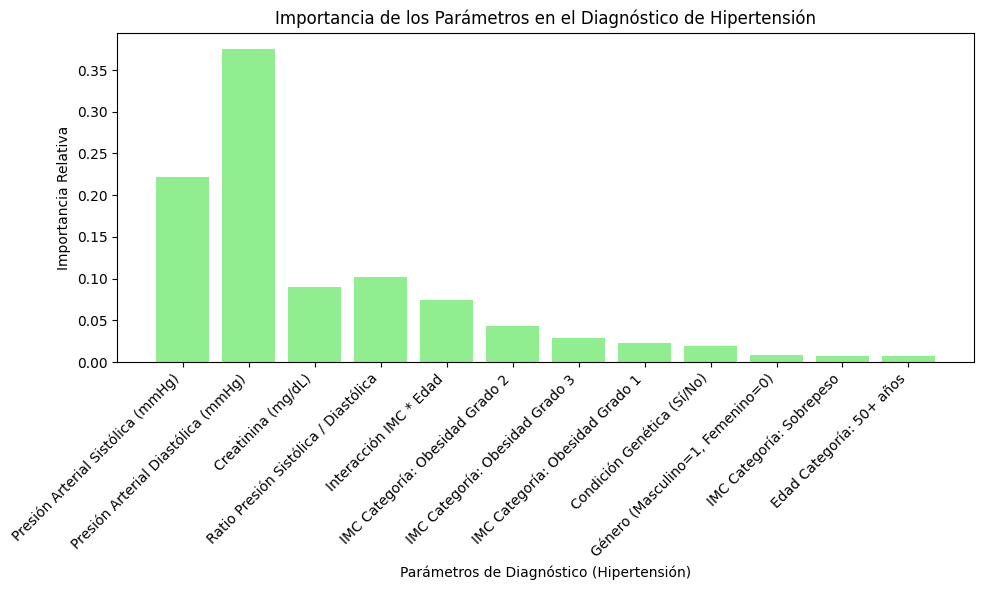

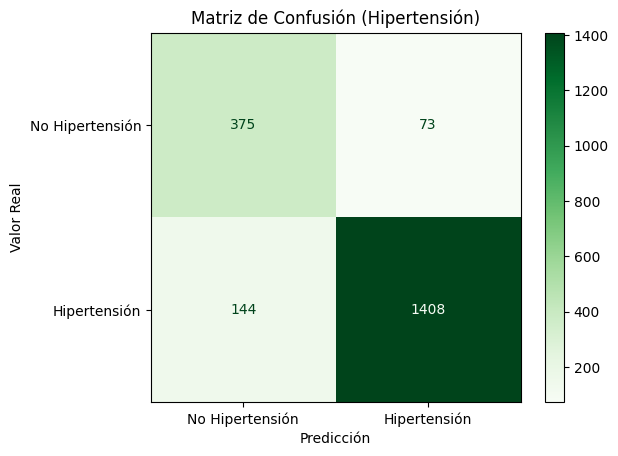

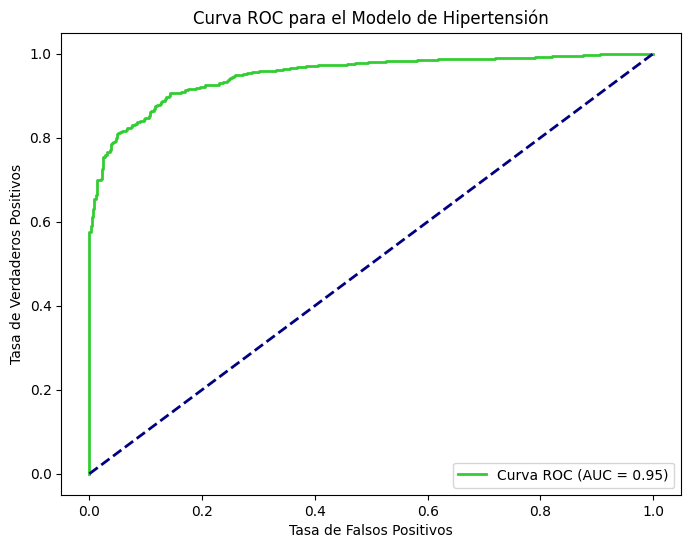

In [12]:
# --- Importancia de las Características (Obesidad) ---
feature_importances_obesity = best_obesity_model.feature_importances_
importance_df_obesity = pd.DataFrame({'feature': features_obesity, 'importance': feature_importances_obesity})

# Priorizar: imc, ldl, trigliceridos; luego el resto
ordered_features = ['IMC Categoría: Sobrepeso', 'IMC Categoría: Obesidad Grado 1', 'IMC Categoría: Obesidad Grado 2', 'IMC Categoría: Obesidad Grado 3', 'ldl', 'trigliceridos'] # Use descriptive names for ordering
ordered_importance = []
for feat_short_name in ordered_features: # Iterate through short names for ordering
    if feat_short_name in importance_df_obesity['feature'].values:
        ordered_importance.append(importance_df_obesity[importance_df_obesity['feature'] == feat_short_name])
remaining = importance_df_obesity[~importance_df_obesity['feature'].isin(ordered_features)]
ordered_importance_df = pd.concat(ordered_importance + [remaining], ignore_index=True)

# Get descriptive labels for features
descriptive_feature_labels_obesity = [feature_name_mapping_obesity.get(feature_short_name, feature_short_name) for feature_short_name in ordered_importance_df['feature']]

plt.figure(figsize=(10,6))
plt.bar(descriptive_feature_labels_obesity, ordered_importance_df['importance'], color='skyblue') # Use descriptive labels here
plt.xlabel('Parámetros de Diagnóstico (Obesidad)')
plt.ylabel('Importancia Relativa')
plt.title('Importancia de los Parámetros en el Diagnóstico de Obesidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cm_obesidad = confusion_matrix(y_test_obesity, y_pred_obesity_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_obesidad, display_labels=['No Obesidad', 'Obesidad'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (Obesidad)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

fpr_obesidad, tpr_obesidad, _ = roc_curve(y_test_obesity, y_pred_prob_obesity)
roc_auc_obesidad = auc(fpr_obesidad, tpr_obesidad)
plt.figure(figsize=(8,6))
plt.plot(fpr_obesidad, tpr_obesidad, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_obesidad:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de Obesidad')
plt.legend(loc="lower right")
plt.show()


# --- Importancia de las Características (Diabetes) ---
feature_importances_diabetes = best_diabetes_model.feature_importances_
importance_df_diabetes = pd.DataFrame({'feature': features_diabetes, 'importance': feature_importances_diabetes})
importance_df_diabetes = importance_df_diabetes.sort_values(by='importance', ascending=False)

# Get descriptive labels for features
descriptive_feature_labels_diabetes = [feature_name_mapping_diabetes.get(feature_short_name, feature_short_name) for feature_short_name in importance_df_diabetes['feature']]


plt.figure(figsize=(10,6))
plt.bar(descriptive_feature_labels_diabetes, importance_df_diabetes['importance'], color='lightcoral') # Use descriptive labels here
plt.xlabel('Parámetros de Diagnóstico (Diabetes)')
plt.ylabel('Importancia Relativa')
plt.title('Importancia de los Parámetros en el Diagnóstico de Diabetes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Matriz de Confusión (Diabetes) ---
cm_diabetes = confusion_matrix(y_test_diabetes, y_pred_diabetes_binary)
disp_diabetes = ConfusionMatrixDisplay(confusion_matrix=cm_diabetes, display_labels=['No Diabetes', 'Diabetes'])
disp_diabetes.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusión (Diabetes)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


# --- Curva ROC y AUC (Diabetes) ---
fpr_diabetes, tpr_diabetes, _ = roc_curve(y_test_diabetes, y_pred_prob_diabetes)
roc_auc_diabetes = auc(fpr_diabetes, tpr_diabetes)
plt.figure(figsize=(8,6))
plt.plot(fpr_diabetes, tpr_diabetes, color='coral', lw=2, label=f'Curva ROC (AUC = {roc_auc_diabetes:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de Diabetes')
plt.legend(loc="lower right")
plt.show()


# --- Importancia de las Características (Hipertensión) ---
feature_importances_hipertension = best_hipertension_model.feature_importances_
feature_names_hipertension = features_hipertension
importance_df_hipertension = pd.DataFrame({'feature': feature_names_hipertension, 'importance': feature_importances_hipertension})

# Ordenar por importancia y luego priorizar presión arterial, creatinina y LDL
importance_df_hipertension = importance_df_hipertension.sort_values(by='importance', ascending=False)
ordered_features_hipertension = ['presion_arterial_sistolica', 'presion_arterial_diastolica', 'creatinina', 'ldl'] # Use short names for ordering, although descriptive would also work now. Using short for consistency
ordered_importance_hipertension = []
remaining_features_importance_hipertension = []

# Keeping ordering logic based on short names, but for labels we will use descriptive
for feature_name in ordered_features_hipertension:
    if feature_name in importance_df_hipertension['feature'].values:
        ordered_importance_hipertension.append(importance_df_hipertension[importance_df_hipertension['feature'] == feature_name])

remaining_features_importance_hipertension = importance_df_hipertension[~importance_df_hipertension['feature'].isin(ordered_features_hipertension)]
ordered_importance_df_hipertension = pd.concat(ordered_importance_hipertension + [remaining_features_importance_hipertension], ignore_index=True)

# Get descriptive labels for features
descriptive_feature_labels_hipertension = [feature_name_mapping_hipertension.get(feature_short_name, feature_short_name) for feature_short_name in ordered_importance_df_hipertension['feature']]


plt.figure(figsize=(10, 6))
plt.bar(descriptive_feature_labels_hipertension, ordered_importance_df_hipertension['importance'], color='lightgreen') # Use descriptive labels here
plt.xlabel('Parámetros de Diagnóstico (Hipertensión)')
plt.ylabel('Importancia Relativa')
plt.title('Importancia de los Parámetros en el Diagnóstico de Hipertensión')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Matriz de Confusión (Hipertensión) ---
cm_hipertension = confusion_matrix(y_test_hipertension, y_pred_hipertension_binary)
disp_hipertension = ConfusionMatrixDisplay(confusion_matrix=cm_hipertension, display_labels=['No Hipertensión', 'Hipertensión'])
disp_hipertension.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión (Hipertensión)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


# --- Curva ROC y AUC (Hipertensión) ---
fpr_hipertension, tpr_hipertension, _ = roc_curve(y_test_hipertension, y_pred_prob_hipertension)
roc_auc_hipertension = auc(fpr_hipertension, tpr_hipertension)

plt.figure(figsize=(8, 6))
plt.plot(fpr_hipertension, tpr_hipertension, color='limegreen', lw=2, label=f'Curva ROC (AUC = {roc_auc_hipertension:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de Hipertensión')
plt.legend(loc="lower right")
plt.show()